# Dynamic Programmig: Policy Evaluation, Policy Iteration, Value Iteration

Vamos implementar o algoritmo de Programação Dinâmica para Avaliação Iterativa de uma Política com Atualizações Síncronas. O problema a ser resolvido é o de posicionamento de um agente em um ambiente Grid World conforme visto em aula:

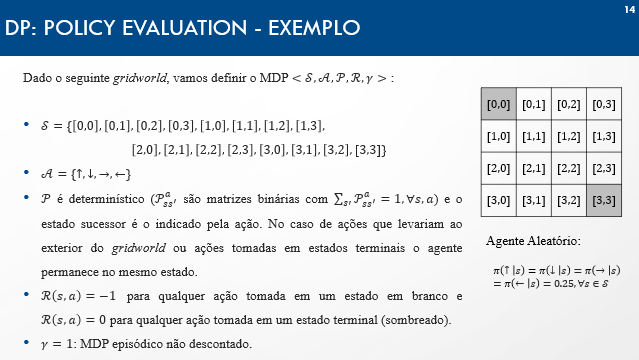




## Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

## Funções Auxiliares

In [36]:
#------------------------------------------------------------------------------
# fig2img(fig)
#
# INPUT:
# fig: matplotlib figure object
#
# OUTPUT:
# img: Image of the given figure
#------------------------------------------------------------------------------
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, orientation='landscape')
    buf.seek(0)
    img = Image.open(buf)
    return img

## Environment Class

In [37]:

#--------------------------------------------
# GridWorld
# PROPERTIES:
# Grid_matrix: 2D Numpy array representing GridWorld (1: Path, 0: Terminal State)
# gamma: Discount Factor
#
# METHODS:
# __init__: Class default constructor
# show(self, state): Show the GridWorld on given state
# step(self, state, action): Perform Environment Dynamics step given state and action
class GridWorld:
    def __init__(self, Grid_matrix, gamma):
        self.Grid_matrix = Grid_matrix
        self.gamma = gamma

        # State Space
        State_Space = []
        for i in range(np.shape(Grid_matrix)[0]):
            for j in range(np.shape(Grid_matrix)[1]):
                State_Space.append(np.array([i,j]))
        # Action Space
        # 'N': North, 'S': South, 'E': East, 'W': West
        Action_Space = ['N','S','E','W']

        self.state_space = State_Space
        self.action_space = Action_Space
    
    
    #------------------------------------------------------------------------------
    # show(self, state)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,) or list)
    # open_figure: Whether to open the matplotlib figure or just return as image
    #
    # OUTPUT:
    # img: Image of the Environment
    #------------------------------------------------------------------------------
    def show(self, state, open_figure=True):
        fig = plt.figure()
        ax = fig.gca()
        # Plot GridWorld
        ax.imshow(self.Grid_matrix, interpolation='nearest', cmap=cm.Greys_r)
        # Plot Agent
        ax.scatter(state[1], state[0], s=128, color='b')

        grid_shape_0 = np.shape(self.Grid_matrix)[0]
        grid_shape_1 = np.shape(self.Grid_matrix)[1]

        for i in range(0, grid_shape_0):
            ax.plot([-0.5, grid_shape_1-0.5], [i-0.5, i-0.5], color='black', alpha=.33, linestyle=':')
        for i in range(0, grid_shape_1):
            ax.plot([i-0.5, i-0.5], [-0.5, grid_shape_0-0.5], color='black', alpha=.33, linestyle=':')
        
        img = fig2img(fig)
        if (open_figure==False):
            plt.close(fig)
            return img
        

        
    #------------------------------------------------------------------------------
    # step(self, state, action)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,) or list)
    # action: Action taken (0: Stand Still, 1: North, 2: South, 3: East, 4: West)
    #
    # OUTPUT:
    # next_state: Next agent position (1D numpy array with shape=(2,) or list)
    # reward: Immediate Reward obtained (float)
    #------------------------------------------------------------------------------
    def step(self, state, action):
            
        # a = 'N': North
        if (action == 'N'):
            next_pos = np.array([state[0] - 1, state[1]])
            if (next_pos[0] < 0 or next_pos[0] >= np.shape(self.Grid_matrix)[0]):
                next_state = state
            else:
                next_state = next_pos
                
        # a = 'S': South
        elif (action == 'S'):
            next_pos = np.array([state[0] + 1, state[1]])
            if (next_pos[0] < 0 or next_pos[0] >= np.shape(self.Grid_matrix)[0]):
                next_state = state
            else:
                next_state = next_pos
        
        # a = 'E': East
        elif (action == 'E'):
            next_pos = np.array([state[0], state[1] + 1])
            if (next_pos[1] < 0 or next_pos[1] >= np.shape(self.Grid_matrix)[1]):
                next_state = state
            else:
                next_state = next_pos
        
        # a = 'W': West
        elif (action == 'W'):
            next_pos = np.array([state[0], state[1] - 1])
            if (next_pos[1] < 0 or next_pos[1] >= np.shape(self.Grid_matrix)[1]):
                next_state = state
            else:
                next_state = next_pos
        
        else:
            print('Invalid Action!')
        
        
        
        # Reward
        done = False
        if (self.Grid_matrix[state[0]][state[1]] == 0):
            done = True
            reward = 0
            next_state = state
        else:
            reward = -1
        
        
        return reward, next_state, done
    

    #------------------------------------------------------------------------------
    # reset(self)
    #
    # INPUT:
    #
    # OUTPUT:
    # initial_state: Initial state randomly sampled from all possible states
    #------------------------------------------------------------------------------
    def reset(self):
        n = len(self.state_space)
        valid_state = False
        while(not valid_state):
            initial_state_index = np.random.choice(np.arange(n))
            initial_state = self.state_space[initial_state_index]
            if (self.Grid_matrix[initial_state[0]][initial_state[1]] == 1):
                valid_state = True

        return initial_state
    


    
                

### Create Environment

State Space: [array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3]), array([1, 0]), array([1, 1]), array([1, 2]), array([1, 3]), array([2, 0]), array([2, 1]), array([2, 2]), array([2, 3]), array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3])]
Action Space: ['N', 'S', 'E', 'W']


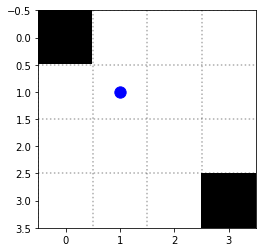

In [38]:
# GridWorld matrix
Grid_matrix = np.array([[0, 1, 1, 1],\
                        [1, 1, 1, 1],\
                        [1, 1, 1, 1],\
                        [1, 1, 1, 0]])
#Grid_matrix = np.array([[0, 1, 1, 1, 1, 1, 1],\
#                        [1, 1, 1, 1, 1, 1, 1],\
#                        [1, 1, 1, 1, 1, 1, 1],\
#                        [1, 1, 1, 1, 1, 1, 1],\
#                        [1, 1, 1, 1, 1, 1, 1],\
#                        [1, 1, 1, 1, 1, 1, 1],\
#                        [1, 1, 1, 1, 1, 1, 0]])

       
# Create Environment
env = GridWorld(Grid_matrix, gamma=1)
env.show(state=np.array([1,1]))

# State Space
state_space = env.state_space
print('State Space: ' + str(state_space))
# Action Space
action_space = env.action_space
print('Action Space: ' + str(action_space))

### Função get_state_index(s)

In [39]:
def get_state_index(state):
    for i in range(0,len(state_space)):
        s = state_space[i]
        if np.all(s == state):
            return i
    
    print('ERROR: State not found!')
    return 0

## Random Policy


In [40]:
n = len(state_space)
m = len(action_space)
random_policy = (1/m)*np.ones((n,m))
print('Random Policy')
print(random_policy)

Random Policy
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


## DP: Iterative Policy Evaluation

Vamos implementar uma função que recebe o ambiente e a política a ser avaliada (assim como um parâmetro de precisão $\theta$) e retorna a função valor $V_{\pi}(s)$ associada a esta política (Model-based Prediction).

A política será codificada como uma matriz de probabilidades de dimensão n x m, onde n e m são as dimensões dos espaços de estados e ações respectivamente.

In [41]:
#------------------------------------------------------------------------------
# IterativePolicyEvaluation(env, policy, theta)
#
# INPUT:
# env: Environment (GridWorld object)
# policy: Proability of taking each action at each state
# (numpy array with shape=(len(STATE_SPACE),len(ACTION_SPACE)))
# theta: Stopping Criterium (max{|V_k+1(s) - V_k(s)|} < theta)
#
# OUTPUT:
# ValueFunction: Value Function V_pi corresponding to given policy
#------------------------------------------------------------------------------
def IterativePolicyEvaluation(env, policy, theta):
    n = len(env.state_space)
    m = len(env.action_space)

    V_old = np.zeros(n)
    
    stop = False
    k = 0
    # While theta precision hasn't been reached yet
    while (stop == False):
        print('k = ' + str(k))
        delta = 0
        V_new = np.zeros(n)
        # For each state in state_space
        for s_index in range(0,n):
            state = env.state_space[s_index]
            new_v = 0
            # sum new_v over actions
            for action_index in range(0,m):
                reward, next_state, done = env.step(state, env.action_space[action_index])
                next_state_index = get_state_index(next_state)
                new_v = new_v + policy[s_index][action_index]*\
                                    (reward + env.gamma*V_old[next_state_index])
            # Update Value of Current State
            V_new[s_index] = new_v
            # Update Delta
            delta = max([delta, abs(V_new[s_index] - V_old[s_index])])
        V_old = np.copy(V_new)
        k = k+1
        if (delta < theta):
            stop = True
    return V_new

In [42]:
V = IterativePolicyEvaluation(env, random_policy, theta=0.0000000001)

k = 0
k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
k = 11
k = 12
k = 13
k = 14
k = 15
k = 16
k = 17
k = 18
k = 19
k = 20
k = 21
k = 22
k = 23
k = 24
k = 25
k = 26
k = 27
k = 28
k = 29
k = 30
k = 31
k = 32
k = 33
k = 34
k = 35
k = 36
k = 37
k = 38
k = 39
k = 40
k = 41
k = 42
k = 43
k = 44
k = 45
k = 46
k = 47
k = 48
k = 49
k = 50
k = 51
k = 52
k = 53
k = 54
k = 55
k = 56
k = 57
k = 58
k = 59
k = 60
k = 61
k = 62
k = 63
k = 64
k = 65
k = 66
k = 67
k = 68
k = 69
k = 70
k = 71
k = 72
k = 73
k = 74
k = 75
k = 76
k = 77
k = 78
k = 79
k = 80
k = 81
k = 82
k = 83
k = 84
k = 85
k = 86
k = 87
k = 88
k = 89
k = 90
k = 91
k = 92
k = 93
k = 94
k = 95
k = 96
k = 97
k = 98
k = 99
k = 100
k = 101
k = 102
k = 103
k = 104
k = 105
k = 106
k = 107
k = 108
k = 109
k = 110
k = 111
k = 112
k = 113
k = 114
k = 115
k = 116
k = 117
k = 118
k = 119
k = 120
k = 121
k = 122
k = 123
k = 124
k = 125
k = 126
k = 127
k = 128
k = 129
k = 130
k = 131
k = 132
k = 133
k = 134
k = 135
k = 136
k = 137
k = 13

## Plot Value Function

In [43]:
def plot_value_function(env,V):
    value_function_matrix = np.zeros(np.shape(env.Grid_matrix))

    for s_index in range(len(V)):
        state = env.state_space[s_index]
        value_function_matrix[state[0]][state[1]] = V[s_index]
    
    print('V = ')
    print(value_function_matrix)

    fig = plt.figure()
    ax = fig.gca()
    C = ax.imshow(value_function_matrix, interpolation='nearest', cmap='RdYlGn') # Plot Value Function Colormap
    fig.colorbar(C, ax=ax) # Add Colorbar
    ax.set_title('GridWorld: Value Function') # Set Title


V = 
[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


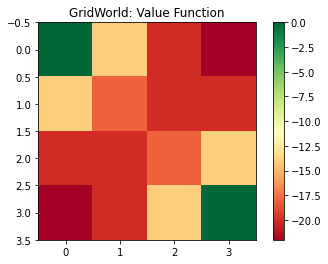

In [44]:
plot_value_function(env,V)

## DP: Policy Iteration

Vamos implementar uma função que implementa o algoritmo de Iteração sobre a Função Política, retornando a função Valor ótima $V^*(s)$ e política ótima $\pi^*$.

Para isso, vamos criar uma função auxiliar de melhoria de política com base em comportamento greedy sobre $V_{\pi}$ e chamar iterativamente as funções de avaliação e melhoria.

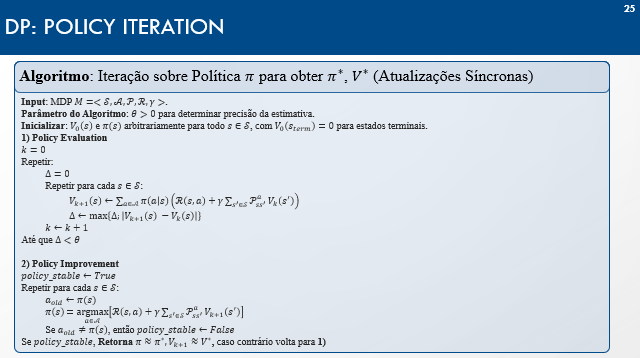

### greedy_improvement(env,V)

In [45]:
#------------------------------------------------------------------------------
# greedy_improvement(env,V)
#
# INPUT:
# env: Environment (GridWorld object)
# V: Value Function (numpy array with shape=(n,), where n = len(state_space))
#
# OUTPUT:
# greedy_policy: 
#------------------------------------------------------------------------------
def greedy_improvement(env,V):
    n = len(env.state_space)
    m = len(env.action_space)
    greedy_policy = np.zeros((n,m))

    if (n != len(V)):
        print('Error: Conflicting number of states in Value Function and environment!')
        return 0
    
    for s_index in range(0,n):
        s = env.state_space[s_index]
        q_list = []
        for action_index in range(0,m):
            a = env.action_space[action_index]
            r, s_next, done = env.step(s,a)
            if (done):
                q_list.append(r)
            else:
                next_state_index = get_state_index(s_next)
                q_list.append(r + env.gamma*V[next_state_index])
        # Greedy Action
        best_action_index = np.argmax(q_list)
        greedy_policy[s_index, best_action_index] = 1
    
    return greedy_policy



In [46]:
pi = greedy_improvement(env,V)
print(pi)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


### check_policy_stable(old_policy, new_policy):
Verifica se políticas antiga e atual são determinísticas e iguais para critério de parada de algoritmo Policy Iteration.

In [47]:
#------------------------------------------------------------------------------
# check_policy_stable(old_policy, new_policy)
#
# INPUT:
# old_policy: Old Policy
# new_policy: New Policy after greedy policy improvement.
#
# OUTPUT:
# stable: Boolean which indicates whether both policies are deterministic and identical
#------------------------------------------------------------------------------
def check_policy_stable(old_policy, new_policy):

  if ((np.shape(old_policy)[0] != np.shape(new_policy)[0]) or \
      (np.shape(old_policy)[1] != np.shape(new_policy)[1])):
    print('ERROR: Conflicting array dimensions for new and old policies!')
    return False
  
  n = np.shape(old_policy)[0]
  m = np.shape(old_policy)[1]

  # Check if policies are deterministic
  deterministic = True
  for i in range(0,n):
    for j in range(0,m):
      if ((old_policy[i][j]!=1 and old_policy[i][j]!=0) or \
          (new_policy[i][j]!=1 and new_policy[i][j]!=0)):
        deterministic = False
        break
  
  if (not deterministic):
    # Policies are not both deterministic!
    return False
  
  # Check if policies are identical
  if np.all(old_policy == new_policy):
    return True
  else:
    return False

### PolicyIteration(env, theta)

In [48]:
#------------------------------------------------------------------------------
# PolicyIteration(env,theta)
#
# INPUT:
# env: GridWorld Environment object.
# theta: Parameter used to control precision of value function estimate (float, >0).
#        (If the maximum absolute difference between the values of a state on subsequent iterations
#        is smaller than theta, then stop).
#
# OUTPUT:
# pi: Optimal Policy (numpy array with shape=(n,m)), n = len(states_list) and m = len(ACTION_SPACE).
# V_pi: Optimal Value Function (numpy array with shape=(n,))
#------------------------------------------------------------------------------
def PolicyIteration(env, theta):
    n = len(env.state_space)
    m = len(env.action_space)   
    # Initialize Policy
    old_pi = (1/m)*np.ones((n,m))
    pi = np.copy(old_pi)

    policy_stable = False
    cont = 0
    while(not policy_stable):
        cont += 1
        print(cont)
        # Policy Evaluation
        print('Policy Evaluation')
        V = IterativePolicyEvaluation(env, old_pi, theta)
        # Policy Improvement
        print('Policy Improvement')
        pi = greedy_improvement(env, V)
        # Check if policy is stable
        policy_stable = check_policy_stable(old_pi, pi)
        # Update Policy
        old_pi = np.copy(pi)
    
    return pi, V

1
Policy Evaluation
k = 0
k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
k = 11
k = 12
k = 13
k = 14
k = 15
k = 16
k = 17
k = 18
k = 19
k = 20
k = 21
k = 22
k = 23
k = 24
k = 25
k = 26
k = 27
k = 28
k = 29
k = 30
k = 31
k = 32
k = 33
k = 34
k = 35
k = 36
k = 37
k = 38
k = 39
k = 40
k = 41
k = 42
k = 43
k = 44
k = 45
k = 46
k = 47
k = 48
k = 49
k = 50
k = 51
k = 52
k = 53
k = 54
k = 55
k = 56
k = 57
k = 58
k = 59
k = 60
k = 61
k = 62
k = 63
k = 64
k = 65
k = 66
k = 67
k = 68
k = 69
k = 70
k = 71
k = 72
k = 73
k = 74
k = 75
k = 76
k = 77
k = 78
k = 79
k = 80
k = 81
k = 82
k = 83
k = 84
k = 85
k = 86
k = 87
k = 88
Policy Improvement
2
Policy Evaluation
k = 0
k = 1
k = 2
k = 3
Policy Improvement
3
Policy Evaluation
k = 0
k = 1
k = 2
k = 3
Policy Improvement
------------------------------------
Optimal Policy:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0.

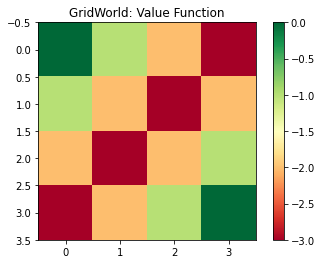

In [49]:
pi_opt, V_opt = PolicyIteration(env, theta=0.01)

# Visualize optimal policy and value function
print('------------------------------------')
print('Optimal Policy:')
print(pi_opt)
print('Optimal Value Function:')
plot_value_function(env,V_opt)

## DP: Value Iteration

Vamos agora obter a função valor ótima $V^*$ pelo algoritmo de iteração sobre a função valor.

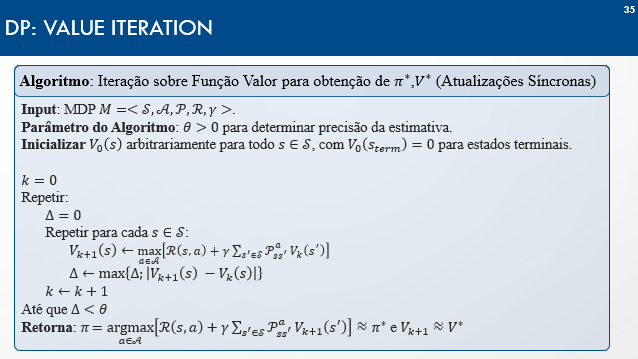

In [50]:
#------------------------------------------------------------------------------
# ValueIteration(env, theta)
#
# INPUT:
# env: Environment (GridWorld object)
# theta: Stopping Criterium (max{|V_k+1(s) - V_k(s)|} < theta)
#
# OUTPUT:
# V_opt: Optimal Value Function
#------------------------------------------------------------------------------
def ValueIteration(env,theta):
    n = len(env.state_space)
    m = len(env.action_space)

    V_old = np.zeros(n)
    
    stop = False
    k = 0
    # While theta precision hasn't been reached yet
    while (stop == False):
        print('k = ' + str(k))
        delta = 0
        V_new = np.zeros(n)
        # For each state in state_space
        for s_index in range(0,n):
            state = env.state_space[s_index]
            q_list = []
            # build list of Q values
            for action_index in range(0,m):
                reward, next_state, done = env.step(state, env.action_space[action_index])
                next_state_index = get_state_index(next_state)
                q = reward + env.gamma*V_old[next_state_index]
                q_list.append(q)
            # Maximize over list of Q values
            V_new[s_index] = np.max(q_list)
            # Update Delta
            delta = max([delta, abs(V_new[s_index] - V_old[s_index])])
        V_old = np.copy(V_new)
        k = k+1
        if (delta < theta):
            stop = True
    return V_new

k = 0
k = 1
k = 2
k = 3
-------------------------
Optimal Value Function:
V = 
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


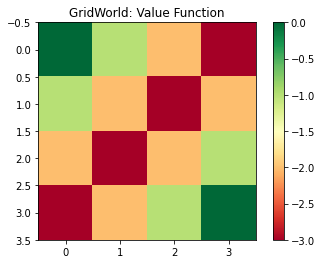

In [51]:
V_opt_VI = ValueIteration(env,theta=0.01)

print('-------------------------')
print('Optimal Value Function:')
plot_value_function(env,V_opt_VI)